# Model-based estimated fisheries nutrition by EEZ

In [1]:
# Import python packages
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mp
import pymc3 as pm
import theano as T
import theano.tensor as tt
import seaborn as sns
import scipy as sp
import pdb
import os as os

# Helper functions
def indexall(L):
    poo = []
    for p in L:
        if not p in poo:
            poo.append(p)
    Ix = np.array([poo.index(p) for p in L])
    return poo,Ix

def subindexall(short,long):
    poo = []
    out = []
    for s,l in zip(short,long):
        if not l in poo:
            poo.append(l)
            out.append(s)
    return indexall(out)

match = lambda a, b: np.array([ b.index(x) if x in b else None for x in a ])
grep = lambda s, l: np.array([i for i in l if s in i])

# Function to standardize covariates
def stdize(x):
    return (x-np.mean(x))/(2*np.std(x))

def spanzero(pair):
    out = True
    if all(pair<0) or all(pair>0):
        out = False
    return out

## Import data sources

In [2]:
# Nutritional data
ndata = pd.read_excel('Joint_Nutrient_data.xlsx')
#Species data
sdata = pd.read_csv('SpeciesList_Fishonly_July2020.csv',";")

In [3]:
sdata.columns.values

array(['UniqueID', 'Data', 'taxon_key', 'ScientificName',
       'ScientificName_corrected', 'Species', 'Level', 'Genus', 'Family',
       'Order', 'Class', 'FamCode', 'GenCode', 'DemersPelagic', 'EnvTemp',
       'DepthRangeShallow', 'DepthRangeDeep', 'Lmax', 'BodyShape',
       'Feeding_path', 'K', 'tm', 'trophic_level', 'DepthRangeDeepLevel',
       'KLevel', 'tmLevel', 'trophic_levelLevel', 'LMaxLevel',
       'BodyShapeILevel', 'EnvTempLevel'], dtype=object)

In [4]:
sdata.shape

(2440, 30)

In [5]:
#sdata = sdata[sdata.Class!='Elasmobranchii']

In [6]:
# Change columns to match previous
sdata['LMax'] = sdata.Lmax
sdata['DemersPelag'] = sdata.DemersPelagic
sdata['BodyShapeI'] = sdata.BodyShape


In [7]:
# Add in mean for missing values
sdata.K = sdata.K.fillna(sdata.K.mean())
sdata.tm = sdata.tm.fillna(sdata.tm.mean())
sdata.trophic_level = sdata.trophic_level.fillna(sdata.trophic_level.mean())
sdata.DepthRangeDeep = sdata.DepthRangeDeep.fillna(sdata.DepthRangeDeep.mean())
sdata.LMax = sdata.LMax.fillna(sdata.LMax.mean())

In [8]:
sdata.shape

(2440, 33)

In [9]:
Nutrients = ['Protein', 'Zinc', 'Iron', 'Calcium', 'Omega3', 'Vitamin_A', 'Selenium']
Nkeys = ['Protein_Value_perc', 'Zn_Value', 'Fe_Value', 'Ca_Value', 'O3_Value', 'VitA_Value', 'Se_Value']
nnutrients = len(Nutrients)

## Import results

In [10]:
Protein = pd.read_csv('Protein_results.csv')
Zinc = pd.read_csv('Zinc_results.csv')
Iron = pd.read_csv('Iron_results.csv')
Calcium = pd.read_csv('Calcium_results.csv')
Omega3 = pd.read_csv('Omega-3_results.csv')
Vitamin_A = pd.read_csv('Vitamin_A_results.csv')
Selenium = pd.read_csv('Selenium_results.csv')

Results = [Protein, Zinc, Iron, Calcium, Omega3, Vitamin_A, Selenium]

In [11]:
Selenium.columns

Index(['Unnamed: 0', 'Intercept', 'pelagic_neritic', 'pelagic_oceanic',
       'benthopelagic', 'reef_associated', 'polar_deep', 'subtropical',
       'tropical', 'MaxDepth', 'TL', 'pelagic', 'LMax', 'elongate',
       'short_deep', 'flat', 'K', 'tm', 'whole_parts', 'whole', 'unknown',
       'Expert', 'FAO', 'nu', 'Sigma', 'demersal', 'temperate', 'fusiform',
       'muscle', 'wet', 'WOS'],
      dtype='object')

In [12]:
varord = ['reef_associated', 'benthopelagic', 'pelagic_neritic',
       'pelagic_oceanic', 'subtropical', 'polar_deep', 'tropical', 'MaxDepth', 'TL',
       'Pelagic', 'LMax', 'short_deep', 'elongate', 'flat', 'K', 'tm', 'whole',
       'whole_part', 'dry', 'Expert', 'FAO']
varnames = ['Reef assoc.', 'Benthopelagic', 'Pelagic-neritic',
       'Pelagic-oceanic', 'Subtropical', 'Polar/deep', 'Tropical', 'Max depth', 'Trophic level',
       'Pelagic', 'Max length', 'Short-deep', 'Elongate', 'Flat', 'K', 'Maturity age', 'Whole',
       'Whole-noparts', 'Dry', 'Expert', 'FAO']
nvar = len(varnames)

# Spp predictions

In [13]:
nrows = sdata.shape[0]
nrows

2440

In [14]:
# Specify nutrient
REZ = Protein

# Add empty columns to SAU data
xmu = np.empty(nrows)
xl95 = np.empty(nrows)
xl50 = np.empty(nrows)
xu50 = np.empty(nrows)
xu95 = np.empty(nrows)

for i in range(nrows):
    #print(i/nrows)
    # μ = β0+β1[Ih]+β2[Ic]+β3*MaxDepth+β4*TL+β5*Pelagic+β6*LMax+β7[Ib]+β8*K+β9*tm+β10[If]+β11[Ip]+β12[Is]
    tmp = sdata.iloc[i]
    # Expected nutrients
    Ex = REZ['Intercept'].values+REZ[tmp['DemersPelag']].values+REZ[tmp['EnvTemp']].values+REZ['MaxDepth'].values*np.log(tmp['DepthRangeDeep'])+REZ['TL'].values*tmp['trophic_level']+REZ['pelagic'].values*1*(tmp['Feeding_path']=='pelagic')+REZ['LMax'].values*np.log(tmp['LMax'])+REZ[tmp['BodyShapeI']].values+REZ['K'].values*tmp['K']+REZ['tm'].values*np.log(tmp['tm'])
    # Scaled to catch - g/100g to kg/yr = g/kg/yr
    #nut = ((np.exp(Ex)-1)*10)*np.log(tmp['kg_year']/1000+1)
    nut = np.exp(Ex)
    
    # Add summary statistics to SAU data
    xmu[i] = max(np.median(nut),0)
    xl95[i] = max(np.percentile(nut,2.5),0)
    xl50[i] = max(np.percentile(nut,25),0)
    xu50[i] = max(np.percentile(nut,75),0)
    xu95[i] = max(np.percentile(nut,97.5),0)
    
sdata['Protein_mu'] = xmu
sdata['Protein_l95'] = xl95
sdata['Protein_l50'] = xl50
sdata['Protein_u50'] = xu50
sdata['Protein_u95'] = xu95

In [15]:
sdata[np.isinf(xmu)]

,UniqueID,Data,taxon_key,ScientificName,ScientificName_corrected,Species,Level,Genus,Family,Order,...,BodyShapeILevel,EnvTempLevel,LMax,DemersPelag,BodyShapeI,Protein_mu,Protein_l95,Protein_l50,Protein_u50,Protein_u95


In [16]:
sdata[xmu==0]

,UniqueID,Data,taxon_key,ScientificName,ScientificName_corrected,Species,Level,Genus,Family,Order,...,BodyShapeILevel,EnvTempLevel,LMax,DemersPelag,BodyShapeI,Protein_mu,Protein_l95,Protein_l50,Protein_u50,Protein_u95


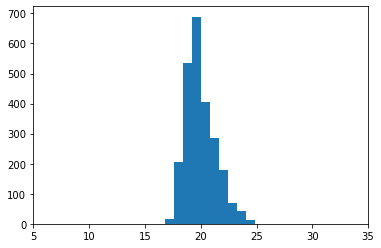

In [17]:
plt.hist(sdata['Protein_mu'])
plt.xlim(5,35);

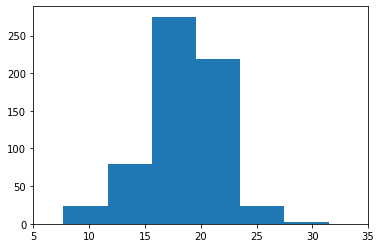

In [18]:
Y_ = ndata.Protein_Value_perc.values
indx = np.isnan(Y_)==False
Y = Y_[indx]
plt.hist(Y,bins=20)
plt.xlim(5,35);

In [19]:
np.percentile(sdata['Protein_mu'],(5,50,95)), np.percentile(Y,(5,50,95))

(array([18.06872594, 19.71527734, 22.45062753]),
 array([12.103, 19.   , 23.5  ]))

In [20]:
REZ.columns

Index(['Unnamed: 0', 'Intercept', 'reef_associated', 'benthopelagic',
       'pelagic_neritic', 'pelagic_oceanic', 'subtropical', 'polar_deep',
       'tropical', 'MaxDepth', 'TL', 'pelagic', 'LMax', 'short_deep',
       'elongate', 'flat', 'K', 'tm', 'whole', 'whole_parts', 'unknown',
       'unknown.1', 'dry', 'Expert', 'FAO', 'Sigma', 'demersal', 'temperate',
       'fusiform', 'muscle', 'wet', 'WOS'],
      dtype='object')

In [21]:
# Specify nutrient
REZ = Zinc

# Add empty columns to SAU data
xmu = np.empty(nrows)
xl95 = np.empty(nrows)
xl50 = np.empty(nrows)
xu50 = np.empty(nrows)
xu95 = np.empty(nrows)

for i in range(nrows):
    #print(i/nrows)
    # μ = β0+β1[Ih]+β2[Ic]+β3*MaxDepth+β4*TL+β5*Pelagic+β6*LMax+β7[Ib]+β8*K+β9*tm+β10[If]+β11[Ip]+β12[Is]
    tmp = sdata.iloc[i]
    # Expected nutrients
    Ex = REZ['Intercept'].values+REZ[tmp['DemersPelag']].values+REZ[tmp['EnvTemp']].values+REZ['MaxDepth'].values*np.log(tmp['DepthRangeDeep'])+REZ['TL'].values*tmp['trophic_level']+REZ['pelagic'].values*1*(tmp['Feeding_path']=='pelagic')+REZ['LMax'].values*np.log(tmp['LMax'])+REZ[tmp['BodyShapeI']].values+REZ['K'].values*tmp['K']+REZ['tm'].values*np.log(tmp['tm'])
    # Scaled to catch - g/100g to kg/yr = g/kg/yr
    #nut = ((np.exp(Ex)-1)*10)*np.log(tmp['kg_year']/1000+1)
    # double exponential - log-link on log scale
    nut = np.exp(np.exp(Ex))-1
    
    # Add summary statistics to SAU data
    xmu[i] = max(np.median(nut),0)
    xl95[i] = max(np.percentile(nut,2.5),0)
    xl50[i] = max(np.percentile(nut,25),0)
    xu50[i] = max(np.percentile(nut,75),0)
    xu95[i] = max(np.percentile(nut,97.5),0)
    
sdata['Zinc_mu'] = xmu
sdata['Zinc_l95'] = xl95
sdata['Zinc_l50'] = xl50
sdata['Zinc_u50'] = xu50
sdata['Zinc_u95'] = xu95

In [22]:
sdata[np.isinf(xmu)]

,UniqueID,Data,taxon_key,ScientificName,ScientificName_corrected,Species,Level,Genus,Family,Order,...,Protein_mu,Protein_l95,Protein_l50,Protein_u50,Protein_u95,Zinc_mu,Zinc_l95,Zinc_l50,Zinc_u50,Zinc_u95


In [23]:
sdata[xmu==0]

,UniqueID,Data,taxon_key,ScientificName,ScientificName_corrected,Species,Level,Genus,Family,Order,...,Protein_mu,Protein_l95,Protein_l50,Protein_u50,Protein_u95,Zinc_mu,Zinc_l95,Zinc_l50,Zinc_u50,Zinc_u95


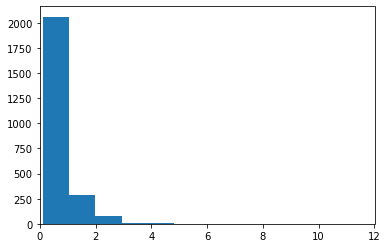

In [24]:
plt.hist(sdata['Zinc_mu'])
plt.xlim(0,12);

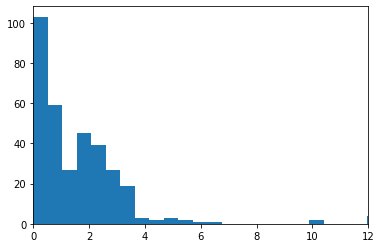

In [25]:
Y_ = ndata.Zn_Value.values
indx = np.isnan(Y_)==False
Y = Y_[indx]
plt.hist(Y,bins=50)
plt.xlim(0,12);

In [26]:
np.percentile(sdata['Zinc_mu'],(5,50,95)), np.percentile(Y,(5,50,95))

(array([0.23253482, 0.64232257, 1.81712178]),
 array([0.193249, 1.297   , 5.56    ]))

In [27]:
# Specify nutrient
REZ = Iron

# Add empty columns to SAU data
xmu = np.empty(nrows)
xl95 = np.empty(nrows)
xl50 = np.empty(nrows)
xu50 = np.empty(nrows)
xu95 = np.empty(nrows)

for i in range(nrows):
    #print(i/nrows)
    # μ = β0+β1[Ih]+β2[Ic]+β3*MaxDepth+β4*TL+β5*Pelagic+β6*LMax+β7[Ib]+β8*K+β9*tm+β10[If]+β11[Ip]+β12[Is]
    tmp = sdata.iloc[i]
    # Expected nutrients
    Ex = REZ['Intercept'].values+REZ[tmp['DemersPelag']].values+REZ[tmp['EnvTemp']].values+REZ['MaxDepth'].values*np.log(tmp['DepthRangeDeep'])+REZ['TL'].values*tmp['trophic_level']+REZ['pelagic'].values*1*(tmp['Feeding_path']=='pelagic')+REZ['LMax'].values*np.log(tmp['LMax'])+REZ[tmp['BodyShapeI']].values+REZ['K'].values*tmp['K']+REZ['tm'].values*np.log(tmp['tm'])
    # Scaled to catch - g/100g to kg/yr = g/kg/yr
    #nut = ((np.exp(Ex)-1)*10)*np.log(tmp['kg_year']/1000+1)
    # double exponential - log-link on log scale
    nut = np.exp(np.exp(Ex))-1
    
    # Add summary statistics to SAU data
    xmu[i] = max(np.median(nut),0)
    xl95[i] = max(np.percentile(nut,2.5),0)
    xl50[i] = max(np.percentile(nut,25),0)
    xu50[i] = max(np.percentile(nut,75),0)
    xu95[i] = max(np.percentile(nut,97.5),0)
    
sdata['Iron_mu'] = xmu
sdata['Iron_l95'] = xl95
sdata['Iron_l50'] = xl50
sdata['Iron_u50'] = xu50
sdata['Iron_u95'] = xu95

In [28]:
sdata[np.isinf(xmu)]

,UniqueID,Data,taxon_key,ScientificName,ScientificName_corrected,Species,Level,Genus,Family,Order,...,Zinc_mu,Zinc_l95,Zinc_l50,Zinc_u50,Zinc_u95,Iron_mu,Iron_l95,Iron_l50,Iron_u50,Iron_u95


In [29]:
sdata[xmu==0]

,UniqueID,Data,taxon_key,ScientificName,ScientificName_corrected,Species,Level,Genus,Family,Order,...,Zinc_mu,Zinc_l95,Zinc_l50,Zinc_u50,Zinc_u95,Iron_mu,Iron_l95,Iron_l50,Iron_u50,Iron_u95


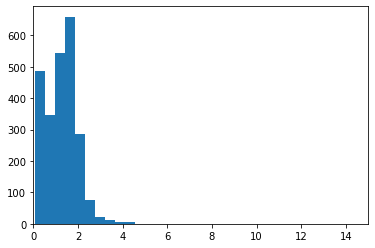

In [30]:
plt.hist(sdata['Iron_mu'],bins=10)
plt.xlim(0,15);

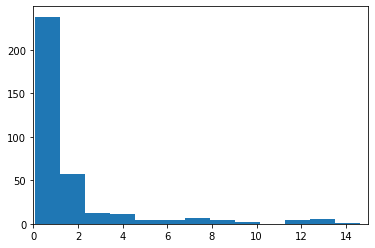

In [31]:
Y_ = ndata.Fe_Value.values
indx = np.isnan(Y_)==False
Y = Y_[indx]
plt.hist(Y,bins=100)
plt.xlim(0,15);

In [32]:
np.percentile(sdata['Iron_mu'],(5,50,95)), np.percentile(Y,(5,50,95))

(array([0.18706291, 1.29644193, 2.30902253]),
 array([0.161965, 0.701   , 7.981565]))

In [33]:
# Specify nutrient
REZ = Calcium

# Add empty columns to SAU data
xmu = np.empty(nrows)
xl95 = np.empty(nrows)
xl50 = np.empty(nrows)
xu50 = np.empty(nrows)
xu95 = np.empty(nrows)

for i in range(nrows):
    #print(i/nrows)
    # μ = β0+β1[Ih]+β2[Ic]+β3*MaxDepth+β4*TL+β5*Pelagic+β6*LMax+β7[Ib]+β8*K+β9*tm+β10[If]+β11[Ip]+β12[Is]
    tmp = sdata.iloc[i]
    # Expected nutrients
    Ex = REZ['Intercept'].values+REZ[tmp['DemersPelag']].values+REZ[tmp['EnvTemp']].values+REZ['MaxDepth'].values*np.log(tmp['DepthRangeDeep'])+REZ['TL'].values*tmp['trophic_level']+REZ['pelagic'].values*1*(tmp['Feeding_path']=='pelagic')+REZ['LMax'].values*np.log(tmp['LMax'])+REZ[tmp['BodyShapeI']].values+REZ['K'].values*tmp['K']+REZ['tm'].values*np.log(tmp['tm'])
    # Scaled to catch - g/100g to kg/yr = g/kg/yr
    #nut = ((np.exp(Ex)-1)*10)*np.log(tmp['kg_year']/1000+1)
    nut = np.exp(Ex)-1
    
    # Add summary statistics to SAU data
    xmu[i] = max(np.median(nut),0)
    xl95[i] = max(np.percentile(nut,2.5),0)
    xl50[i] = max(np.percentile(nut,25),0)
    xu50[i] = max(np.percentile(nut,75),0)
    xu95[i] = max(np.percentile(nut,97.5),0)
    
sdata['Calcium_mu'] = xmu
sdata['Calcium_l95'] = xl95
sdata['Calcium_l50'] = xl50
sdata['Calcium_u50'] = xu50
sdata['Calcium_u95'] = xu95

In [34]:
sdata[np.isinf(xmu)]

,UniqueID,Data,taxon_key,ScientificName,ScientificName_corrected,Species,Level,Genus,Family,Order,...,Iron_mu,Iron_l95,Iron_l50,Iron_u50,Iron_u95,Calcium_mu,Calcium_l95,Calcium_l50,Calcium_u50,Calcium_u95


In [35]:
sdata[xmu==0]

,UniqueID,Data,taxon_key,ScientificName,ScientificName_corrected,Species,Level,Genus,Family,Order,...,Iron_mu,Iron_l95,Iron_l50,Iron_u50,Iron_u95,Calcium_mu,Calcium_l95,Calcium_l50,Calcium_u50,Calcium_u95


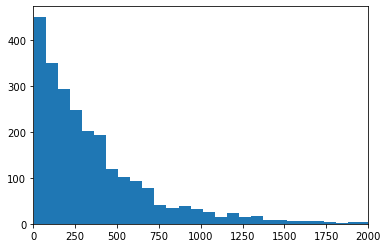

In [36]:
plt.hist(sdata['Calcium_mu'],bins=50)
plt.xlim(0,2000);

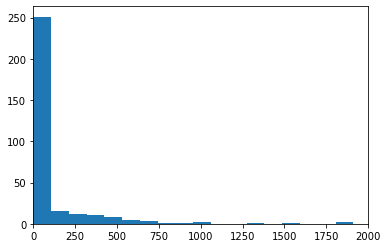

In [37]:
Y_ = ndata.Ca_Value.values
indx = np.isnan(Y_)==False
Y = Y_[indx]
plt.hist(Y,bins=50)
plt.xlim(0,2000);

In [38]:
np.percentile(sdata['Calcium_mu'],(5,50,95)), np.percentile(Y,(5,50,95))

(array([  23.70188112,  252.81560509, 1150.868279  ]),
 array([  5.78 ,  34.593, 611.65 ]))

In [39]:
# Specify nutrient
REZ = Omega3

# Add empty columns to SAU data
xmu = np.empty(nrows)
xl95 = np.empty(nrows)
xl50 = np.empty(nrows)
xu50 = np.empty(nrows)
xu95 = np.empty(nrows)

for i in range(nrows):
    #print(i/nrows)
    # μ = β0+β1[Ih]+β2[Ic]+β3*MaxDepth+β4*TL+β5*Pelagic+β6*LMax+β7[Ib]+β8*K+β9*tm+β10[If]+β11[Ip]+β12[Is]
    tmp = sdata.iloc[i]
    # Expected nutrients
    Ex = REZ['Intercept'].values+REZ[tmp['DemersPelag']].values+REZ[tmp['EnvTemp']].values+REZ['MaxDepth'].values*np.log(tmp['DepthRangeDeep'])+REZ['TL'].values*tmp['trophic_level']+REZ['pelagic'].values*1*(tmp['Feeding_path']=='pelagic')+REZ['LMax'].values*np.log(tmp['LMax'])+REZ[tmp['BodyShapeI']].values+REZ['K'].values*tmp['K']+REZ['tm'].values*np.log(tmp['tm'])
    # Scaled to catch - g/100g to kg/yr = g/kg/yr
    #nut = ((np.exp(Ex)-1)*10)*np.log(tmp['kg_year']/1000+1)
    nut = np.exp(Ex)-1
    
    # Add summary statistics to SAU data
    xmu[i] = max(np.median(nut),0)
    xl95[i] = max(np.percentile(nut,2.5),0)
    xl50[i] = max(np.percentile(nut,25),0)
    xu50[i] = max(np.percentile(nut,75),0)
    xu95[i] = max(np.percentile(nut,97.5),0)
    
sdata['Omega3_mu'] = xmu
sdata['Omega3_l95'] = xl95
sdata['Omega3_l50'] = xl50
sdata['Omega3_u50'] = xu50
sdata['Omega3_u95'] = xu95

In [40]:
sdata[np.isinf(xmu)]

,UniqueID,Data,taxon_key,ScientificName,ScientificName_corrected,Species,Level,Genus,Family,Order,...,Calcium_mu,Calcium_l95,Calcium_l50,Calcium_u50,Calcium_u95,Omega3_mu,Omega3_l95,Omega3_l50,Omega3_u50,Omega3_u95


In [41]:
sdata[xmu==0]

,UniqueID,Data,taxon_key,ScientificName,ScientificName_corrected,Species,Level,Genus,Family,Order,...,Calcium_mu,Calcium_l95,Calcium_l50,Calcium_u50,Calcium_u95,Omega3_mu,Omega3_l95,Omega3_l50,Omega3_u50,Omega3_u95


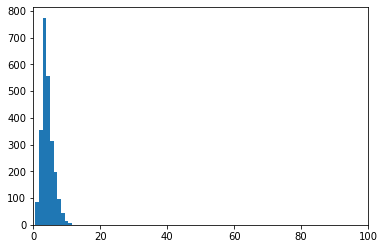

In [42]:
plt.hist(sdata['Omega3_mu'])
plt.xlim(0,100);

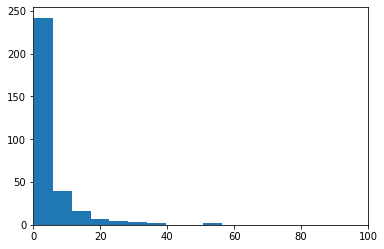

In [43]:
Y_ = ndata.O3_Value.values
indx = np.isnan(Y_)==False
Y = Y_[indx]*10
plt.hist(Y,bins=100)
plt.xlim(0,100);

In [44]:
np.percentile(sdata['Omega3_mu']*10,(5,50,95)), np.percentile(Y,(5,50,95))

(array([18.84814046, 38.95686535, 75.58527834]),
 array([ 0.6905  ,  2.0932  , 20.862214]))

In [45]:
# Specify nutrient
REZ = Vitamin_A

# Add empty columns to SAU data
xmu = np.empty(nrows)
xl95 = np.empty(nrows)
xl50 = np.empty(nrows)
xu50 = np.empty(nrows)
xu95 = np.empty(nrows)

for i in range(nrows):
    #print(i/nrows)
    # μ = β0+β1[Ih]+β2[Ic]+β3*MaxDepth+β4*TL+β5*Pelagic+β6*LMax+β7[Ib]+β8*K+β9*tm+β10[If]+β11[Ip]+β12[Is]
    tmp = sdata.iloc[i]
    # Expected nutrients
    Ex = REZ['Intercept'].values+REZ[tmp['DemersPelag']].values+REZ[tmp['EnvTemp']].values+REZ['MaxDepth'].values*np.log(tmp['DepthRangeDeep'])+REZ['TL'].values*tmp['trophic_level']+REZ['pelagic'].values*1*(tmp['Feeding_path']=='pelagic')+REZ['LMax'].values*np.log(tmp['LMax'])+REZ[tmp['BodyShapeI']].values+REZ['K'].values*tmp['K']+REZ['tm'].values*np.log(tmp['tm'])
    # Scaled to catch - g/100g to kg/yr = g/kg/yr
    #nut = ((np.exp(Ex)-1)*10)*np.log(tmp['kg_year']/1000+1)
    nut = np.exp(Ex)-1
    
    # Add summary statistics to SAU data
    xmu[i] = max(np.median(nut),0)
    xl95[i] = max(np.percentile(nut,2.5),0)
    xl50[i] = max(np.percentile(nut,25),0)
    xu50[i] = max(np.percentile(nut,75),0)
    xu95[i] = max(np.percentile(nut,97.5),0)
    
sdata['Vitamin_A_mu'] = xmu
sdata['Vitamin_A_l95'] = xl95
sdata['Vitamin_A_l50'] = xl50
sdata['Vitamin_A_u50'] = xu50
sdata['Vitamin_A_u95'] = xu95

In [46]:
sdata[np.isinf(xmu)]

,UniqueID,Data,taxon_key,ScientificName,ScientificName_corrected,Species,Level,Genus,Family,Order,...,Omega3_mu,Omega3_l95,Omega3_l50,Omega3_u50,Omega3_u95,Vitamin_A_mu,Vitamin_A_l95,Vitamin_A_l50,Vitamin_A_u50,Vitamin_A_u95


In [47]:
sdata[xmu==0]

,UniqueID,Data,taxon_key,ScientificName,ScientificName_corrected,Species,Level,Genus,Family,Order,...,Omega3_mu,Omega3_l95,Omega3_l50,Omega3_u50,Omega3_u95,Vitamin_A_mu,Vitamin_A_l95,Vitamin_A_l50,Vitamin_A_u50,Vitamin_A_u95
266,1073,initial,600391.0,Brama brama,Brama brama,Brama brama,species,Brama,Bramidae,Perciformes,...,2.928406,1.083102,2.151708,3.914999,6.508558,0.0,0.0,0.0,1.292255,26.842033
286,178,SAU,601225.0,Calamus leucosteus,Calamus leucosteus,Calamus leucosteus,species,Calamus,Sparidae,Perciformes,...,3.474054,1.598506,2.719806,4.407026,6.817203,0.0,0.0,0.0,0.967519,9.572231
325,264,SAU,601907.0,Carangoides hedlandensis,Carangoides hedlandensis,Carangoides hedlandensis,species,Carangoides,Carangidae,Perciformes,...,1.162320,0.000000,0.219853,2.768071,10.108259,0.0,0.0,0.0,1.736128,34.104011
361,1143,initial,614242.0,Centriscops humerosus,Centriscops humerosus,Centriscops humerosus,species,Centriscops,Centriscidae,Syngnathiformes,...,6.909025,3.091406,5.343792,8.977242,14.354733,0.0,0.0,0.0,0.075779,6.210481
543,676,SAU,608838.0,Clidoderma asperrimum,Clidoderma asperrimum,Clidoderma asperrimum,species,Clidoderma,Pleuronectidae,Pleuronectiformes,...,6.619545,2.997134,5.126800,8.509738,13.649496,0.0,0.0,0.0,1.067411,9.943840
621,1331,initial,600062.0,Cyclopterus lumpus,Cyclopterus lumpus,Cyclopterus lumpus,species,Cyclopterus,Cyclopteridae,Scorpaeniformes,...,5.528061,2.534119,4.301938,7.131553,11.239088,0.0,0.0,0.0,0.000000,3.635506
678,1366,initial,601048.0,Diapterus rhombeus,Diapterus rhombeus,Diapterus rhombeus,species,Diapterus,Gerreidae,Perciformes,...,3.825601,0.266585,2.047353,6.576892,17.500637,0.0,0.0,0.0,1.035540,14.593251
815,1466,initial,601391.0,Etelis oculatus,Etelis oculatus,Etelis oculatus,species,Etelis,Lutjanidae,Perciformes,...,3.701201,1.655392,2.868521,4.715840,7.396536,0.0,0.0,0.0,0.936687,14.321134
821,369,SAU,604221.0,Etropus crossotus,Etropus crossotus,Etropus crossotus,species,Etropus,Paralichthyidae,Pleuronectiformes,...,5.286659,1.363322,3.492653,7.738660,15.606048,0.0,0.0,0.0,1.156490,10.634168
826,1475,initial,NaN,Eubalichthys gunnii,Eubalichthys gunnii,Eubalichthys gunnii,species,Eubalichthys,Monacanthidae,Tetraodontiformes,...,4.091599,1.840572,3.170201,5.222155,8.185710,0.0,0.0,0.0,1.103426,10.141070


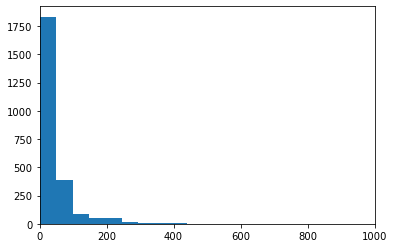

In [48]:
plt.hist(sdata['Vitamin_A_mu'])
plt.xlim(0,1000);

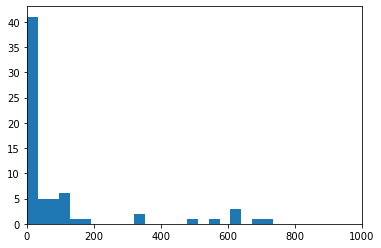

In [49]:
Y_ = ndata.VitA_Value.values
indx = np.isnan(Y_)==False
Y = Y_[indx]
plt.hist(Y,bins=100)
plt.xlim(0,1000);

In [50]:
np.percentile(sdata['Vitamin_A_mu'],(5,50,95)), np.percentile(Y,(5,50,95))

(array([  1.3214817 ,  20.66507906, 166.37813528]), array([  0.,  17., 620.]))

In [51]:
# Specify nutrient
REZ = Selenium

# Add empty columns to SAU data
xmu = np.empty(nrows)
xl95 = np.empty(nrows)
xl50 = np.empty(nrows)
xu50 = np.empty(nrows)
xu95 = np.empty(nrows)

for i in range(nrows):
    #print(i/nrows)
    # μ = β0+β1[Ih]+β2[Ic]+β3*MaxDepth+β4*TL+β5*Pelagic+β6*LMax+β7[Ib]+β8*K+β9*tm+β10[If]+β11[Ip]+β12[Is]
    tmp = sdata.iloc[i]
    # Expected nutrients
    Ex = REZ['Intercept'].values+REZ[tmp['DemersPelag']].values+REZ[tmp['EnvTemp']].values+REZ['MaxDepth'].values*np.log(tmp['DepthRangeDeep'])+REZ['TL'].values*tmp['trophic_level']+REZ['pelagic'].values*1*(tmp['Feeding_path']=='pelagic')+REZ['LMax'].values*np.log(tmp['LMax'])+REZ[tmp['BodyShapeI']].values+REZ['K'].values*tmp['K']+REZ['tm'].values*np.log(tmp['tm'])
    # Scaled to catch - g/100g to kg/yr = g/kg/yr
    #nut = ((np.exp(Ex)-1)*10)*np.log(tmp['kg_year']/1000+1)
    nut = np.exp(Ex)-1
    
    # Add summary statistics to SAU data
    xmu[i] = max(np.median(nut),0)
    xl95[i] = max(np.percentile(nut,2.5),0)
    xl50[i] = max(np.percentile(nut,25),0)
    xu50[i] = max(np.percentile(nut,75),0)
    xu95[i] = max(np.percentile(nut,97.5),0)
    
sdata['Selenium_mu'] = xmu
sdata['Selenium_l95'] = xl95
sdata['Selenium_l50'] = xl50
sdata['Selenium_u50'] = xu50
sdata['Selenium_u95'] = xu95

In [52]:
sdata[np.isinf(xmu)]

,UniqueID,Data,taxon_key,ScientificName,ScientificName_corrected,Species,Level,Genus,Family,Order,...,Vitamin_A_mu,Vitamin_A_l95,Vitamin_A_l50,Vitamin_A_u50,Vitamin_A_u95,Selenium_mu,Selenium_l95,Selenium_l50,Selenium_u50,Selenium_u95


In [53]:
sdata[xmu==0]

,UniqueID,Data,taxon_key,ScientificName,ScientificName_corrected,Species,Level,Genus,Family,Order,...,Vitamin_A_mu,Vitamin_A_l95,Vitamin_A_l50,Vitamin_A_u50,Vitamin_A_u95,Selenium_mu,Selenium_l95,Selenium_l50,Selenium_u50,Selenium_u95


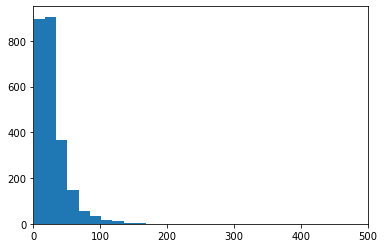

In [54]:
plt.hist(sdata['Selenium_mu'])
plt.xlim(0,500);

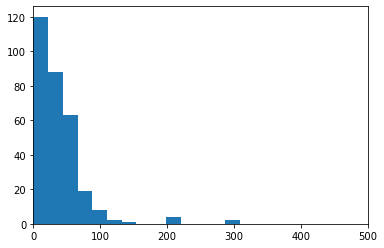

In [55]:
Y_ = ndata.Se_Value.values
indx = np.isnan(Y_)==False
Y = Y_[indx]
plt.hist(Y,bins=100)
plt.xlim(0,500);

In [56]:
np.percentile(sdata['Selenium_mu'],(5,50,95)), np.percentile(Y,(5,50,95))

(array([ 5.93359539, 21.85192534, 67.80787365]),
 array([  0.6736,  31.    , 100.    ]))

In [57]:
sdata.iloc[[list(sdata.ScientificName_corrected.values).index(s) for s in sdata.ScientificName_corrected.unique()],].to_csv('SppNutrients.csv')

In [58]:
sdata.head

<bound method NDFrame.head of       UniqueID     Data  taxon_key             ScientificName  \
0            2      SAU   600009.0        Abalistes stellaris   
1          878  initial   600972.0             Ablennes hians   
2          154      SAU   601119.0        Abudefduf saxatilis   
3          496      SAU   605687.0  Abudefduf septemfasciatus   
4          497      SAU   605688.0     Abudefduf sexfasciatus   
...        ...      ...        ...                        ...   
2435      2606  initial   601370.0                 Zeus faber   
2436      2607  initial   600480.0         Zoarces americanus   
2437      2609  initial   600479.0          Zoarces viviparus   
2438       524      SAU   605772.0           Zoramia gilberti   
2439       525      SAU   605774.0            Zoramia perlita   

       ScientificName_corrected                    Species    Level  \
0           Abalistes stellaris        Abalistes stellaris  species   
1                Ablennes hians             Abl